# Figures for Mapping GHG emissions paper

In [ ]:
import itertools
import wbdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#fc8d59', '#4575b4',  '#d73027', '#91bfdb', '#191922', '#d3d3d3']

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

output_path = '/figures/'

In [2]:
# Load data
path = '/data/'
data = pd.read_parquet(path+'combined/240325_All/facilityEmissions_all.parquet')

In [3]:
years = [str(i) for i in range(1978, 2051)]
years_sigma = [year+'_sigma' for year in years]
data_filt = data[['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']+years+ years_sigma]
data_filt = data_filt.groupby(['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']).sum().reset_index()

data_filt['Product group'] = data_filt['Product group'].replace({'Thermosets, fibre & elastomers':'Thermosets, fibres\n& elastomers', 'Solvents, additives & explosives': 'Solvents, additives\n& explosives'})
data_filt['Type'] = data_filt['Type'].replace({'Direct Utilities':'Direct Energy Use', 'Indirect Utilities': 'Indirect Energy Use'})

data_with_elec = data_filt[[i not in ['EI & CM', 'IHS CtOG'] for i in data_filt['Type']]]
data_filt = data_filt[[i not in ['EI & CM', 'Electricity', 'IHS CtOG'] for i in data_filt['Type']]]

year_used = '2020'
counting_types = ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']
scale_factor = 1E3

## Figure 2 - Map evolution

In [4]:
production_file = path+'processed/icisFacilityProduction_w_uncertainties.csv'
country_groupings_file = path+'extra_inputs/country_regions.csv'

In [5]:
scale_factor = 1E-3 # Convert to Mt for plot

# Production
production_facils = pd.read_csv(production_file, index_col=0)
production = production_facils.groupby(['COUNTRY/TERRITORY']).sum().reset_index().drop(columns=['#', 'START_YR', 'LATITUDE', 'LONGITUDE'])

country_groupings = pd.read_csv(country_groupings_file)
production = pd.merge(production, country_groupings, on='COUNTRY/TERRITORY', how='left')

country_prod = production.groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
country_replace_dict = {'United States': 'USA', 'Taiwan, Province Of China':'Taiwan', 'Netherlands-The':'Netherlands', 'Russian Federation':'Russia', 'Hong Kong Special Administrative Region':'Hong Kong', 'Dominican Republ.':'Dominican Republic', 'Congo (Dem.Rep.)':'Democratic Republic of the Congo', 'Congo':'Democratic Republic of the Congo', 'Congo Republic':'Republic of the Congo', 'Slovak Republic':'Slovakia', 'Serbia/Montenegro/Kosovo':'Serbia', 'Bosnia/Herzegovina':'Bosnia and Herzegovina', 'Myanmar(Burma)':'Myanmar', 'Papua N.G.':'Papua New Guinea'}

country_prod['COUNTRY/TERRITORY'] = country_prod['COUNTRY/TERRITORY'].str.title().replace(country_replace_dict)
country_prod = country_prod[['COUNTRY/TERRITORY']+ years+years_sigma]
country_prod.set_index('COUNTRY/TERRITORY', inplace=True)

top_countries =  ['China','USA','South Korea','India','Russia','Saudi Arabia','Taiwan','Germany', 'Japan'] 

other = pd.DataFrame(country_prod[[i not in top_countries for i in country_prod.index]].sum()).transpose()
other.index = ['Other']
other.index.name = 'COUNTRY/TERRITORY'
country_prod_plot = pd.concat((country_prod.loc[top_countries], other))
country_prod_plot = country_prod_plot*scale_factor

In [ ]:
# Emissions
counting_types = ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']#['Downstream']

country_ems = filter_df(data_filt, ['Gas', 'Type'],[['CO2e_100a'], counting_types]).groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
country_ems = country_ems[['COUNTRY/TERRITORY']+ years+years_sigma]
country_ems.set_index('COUNTRY/TERRITORY', inplace=True)

other = pd.DataFrame(country_ems[[i not in top_countries for i in country_ems.index]].sum()).transpose()
other.index = ['Other']
other.index.name = 'COUNTRY/TERRITORY'
country_ems_plot = pd.concat((country_ems.loc[top_countries], other))
country_ems_plot = country_ems_plot*scale_factor

# Emission factors
total_ems = filter_df(data_filt, ['Gas'],[['CO2e_100a']]).groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
efs = total_ems.merge(country_prod, on='COUNTRY/TERRITORY', how='left')
ef_tops = efs[[i in top_countries for i in efs['COUNTRY/TERRITORY']]]
other = pd.DataFrame(efs[[i not in top_countries for i in efs['COUNTRY/TERRITORY']]].sum()).transpose()
other['COUNTRY/TERRITORY'] = 'Other'
efs = pd.concat((ef_tops, other)).reset_index(drop=True)

years = [str(i) for i in range(1978, 2051)]
for year in years:
    efs[year] = efs[year+'_x']/(efs[year+'_y']+1)
    efs[year+'_sigma'] = efs[year]*[np.sqrt(i) for i in ((efs[year+'_sigma_x']/(efs[year+'_x'].values+1))**2+(efs[year+'_sigma_y']/(efs[year+'_y'].values+1))**2)]

efs = efs[[i for i in efs.columns if '_x' not in i and '_y' not in i]]

efs = efs[['COUNTRY/TERRITORY']+ years+years_sigma]
efs.set_index('COUNTRY/TERRITORY', inplace=True)
# 
# other = pd.DataFrame(efs[[i not in ['China','USA','South Korea','India','Russia','Saudi Arabia','Taiwan','Germany'] for i in efs.index]].sum()).transpose()
# other.index = ['Other']
# other.index.name = 'COUNTRY/TERRITORY'
# efs = pd.concat((efs[:8], other))

In [8]:
# GDP
indicators = {'NY.GDP.MKTP.CD': 'GDP', 'SP.POP.TOTL': 'Population'}
wb_data = wbdata.get_dataframe(indicators).reset_index()

country_conv = {'Egypt, Arab Rep.':'Egypt', 'Czechia':'Czech Republic', 'North Macedonia':'Macedonia', 'Russian Federation':'Russia', 'Bahamas, The':'Bahamas', 'Trinidad and Tobago':'Trinidad', 'United States': 'USA', 'Korea, Rep.': 'South Korea', }

wb_data['country'] = wb_data['country'].replace(country_conv)
wb_data['GDP_capita'] = (wb_data['GDP']/wb_data['Population']).astype(float)

gdp_data = wb_data.pivot(index='country', columns='date', values='GDP_capita').reset_index()
pop_data = wb_data.pivot(index='country', columns='date', values='Population').reset_index()

## Take only relevant years
gdp_data = gdp_data[['country']+[str(i) for i in range(1978, 2022)]]
gdp_data = gdp_data.set_index('country').interpolate(method='linear', axis=1, limit_direction='both').reset_index()
gdp_data = gdp_data.rename(columns={'country':'COUNTRY/TERRITORY'}).set_index('COUNTRY/TERRITORY')

In [9]:
ems_capita = country_ems.merge(pop_data, left_on='COUNTRY/TERRITORY', right_on='country', how='left')
years = [str(i) for i in range(1978, 2022)]
years_sigma = [year+'_sigma' for year in years]
for year in years:
    ems_capita[year] = ems_capita[year+'_x']/ems_capita[year+'_y']
    ems_capita[year+'_sigma'] = ems_capita[year+'_sigma']/ems_capita[year+'_y']
ems_capita = ems_capita[[i for i in ems_capita.columns if '_x' not in i and '_y' not in i]]
ems_capita = ems_capita[['country']+years+years_sigma].rename(columns={'country':'COUNTRY/TERRITORY'}).set_index('COUNTRY/TERRITORY')
scale_factor = 1E6
ems_capita[years] = ems_capita[years].values*scale_factor
ems_capita[years_sigma] = ems_capita[years_sigma].values*scale_factor

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_77088/3711870234.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


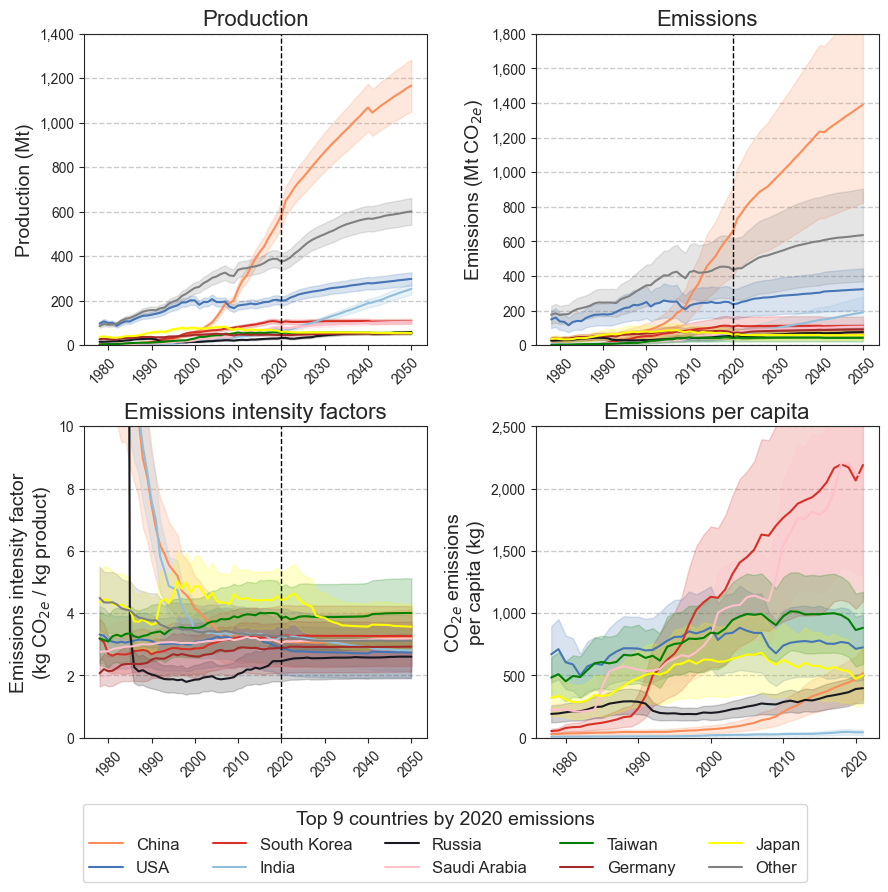

In [11]:
sns.set_style('ticks')

fig = plt.figure(figsize=[9,8], facecolor='white')
fontsize=14

# Production
years = [str(i) for i in range(1978, 2051)]
years_sigma = [year+'_sigma' for year in years]
ax = fig.add_subplot(2,2,1)

colors_used = colors[:-1]+['pink', 'green', 'brown', 'yellow', 'grey']

countries = ['China','USA','South Korea','India','Russia','Saudi Arabia','Taiwan','Germany','Japan']

# # Plot faint grey lines for every country
# for index, row in country_prod_plot.iterrows():
#     ax.plot(years, row[years], color='grey', linewidth=0.5, alpha=0.5)

# For the top countries, plot the uncertainty area
for (index, row), color in zip(country_prod_plot.iterrows(), colors_used):
    # Upper and lower bounds of the uncertainty
    upper_bound = row[years].values + row[years_sigma].values
    lower_bound = row[years].values - row[years_sigma].values
    
    ax.fill_between(years, lower_bound.astype(float), upper_bound.astype(float), alpha=0.2, label=None, color=color)
    # Plotting the mean value line on top of the filled area for clarity
    ax.plot(years, row[years], label=f"{index}", color=color)


# Emissions
ax2 = fig.add_subplot(2,2,2)
# Plot faint grey lines for every country
# for index, row in country_ems.iterrows():
#     ax2.plot(years, row[years], color='grey', linewidth=0.5, alpha=0.5)

# For the top countries, plot the uncertainty area
for (index, row), color in zip(country_ems_plot.iterrows(), colors_used):
    # Upper and lower bounds of the uncertainty
    upper_bound = row[years].values + row[years_sigma].values
    lower_bound = row[years].values - row[years_sigma].values
    
    ax2.fill_between(years, lower_bound.astype(float), upper_bound.astype(float), alpha=0.2, label=None, color=color)
    # Plotting the mean value line on top of the filled area for clarity
    ax2.plot(years, row[years], label=f"{index}", color=color)
    
# Emissions factors
ax3 = fig.add_subplot(2,2,3)
# Plot faint grey lines for every country
# for index, row in efs.iterrows():
#     ax3.plot(years, row[years], color='grey', linewidth=0.5, alpha=0.5)

# For the top countries, plot the uncertainty area
for (index, row), color in zip(efs.iterrows(), colors_used):
    # Upper and lower bounds of the uncertainty
    upper_bound = row[years].values + row[years_sigma].values
    lower_bound = row[years].values - row[years_sigma].values
    
    ax3.fill_between(years, lower_bound.astype(float), upper_bound.astype(float), alpha=0.2, label=None, color=color)
    # Plotting the mean value line on top of the filled area for clarity
    ax3.plot(years, row[years], label=f"{index}", color=color)
    

# GDP plot
ax4 = fig.add_subplot(2,2,4)

countries_no_T = ['China','USA','South Korea','India','Russia','Saudi Arabia','Germany', 'Japan']
years = [str(i) for i in range(1978, 2022)]
years_sigma = [year+'_sigma' for year in years]

# Plot faint grey lines for every country
# for index, row in ems_capita.iterrows():
#     if row.name in gdp_data.index:
#         ax4.scatter(gdp_data.loc[row.name]['2020'].astype(float), row['2020'], color='grey', linewidth=0.5, alpha=0.5)
# 

for (index, row), color in zip(ems_capita.loc[countries_no_T].iterrows(), colors_used[:-3]+colors_used[-2:]):
    # Upper and lower bounds of the uncertainty
    upper_bound = row[years].values + row[years_sigma].values
    lower_bound = row[years].values - row[years_sigma].values
    # 
    # ax4.fill_between(gdp_data.loc[row.name].values.astype(float), lower_bound.astype(float), upper_bound.astype(float), alpha=0.2, label=None, color=color)
    # # Plotting the mean value line on top of the filled area for clarity
    # ax4.plot(gdp_data.loc[row.name].values.astype(float), row[years], label=f"{index}", color=color)
    ax4.fill_between(years, lower_bound.astype(float), upper_bound.astype(float), alpha=0.2, label=None, color=color)
    # Plotting the mean value line on top of the filled area for clarity
    ax4.plot(years, row[years], label=f"{index}", color=color)

ax.set_title('Production', fontsize=fontsize+2)
ax.set_ylabel('Production (Mt)', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_ticks(np.arange(2, 73, 10))
ax.set_xticklabels(np.arange(1980, 2051, 10), rotation=45, rotation_mode='anchor')
ax.grid(axis='y',linestyle='--', linewidth=1)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.vlines('2020', 0, 1.5E6, color='black', linestyle='--', linewidth=1)
ax.set_ylim([0,1.4E3])


ax2.set_title('Emissions', fontsize=fontsize+2)
ax2.set_ylabel('Emissions (Mt CO$_{2e}$)', fontsize=fontsize)
ax2.xaxis.set_ticks(np.arange(2, 73, 10))
ax2.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax2.grid(axis='y',linestyle='--', linewidth=1)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.legend(loc='upper left', fontsize=fontsize-1, fancybox=True)
ax2.vlines('2020', 0, 1.7E6, color='black', linestyle='--', linewidth=1)
ax2.set_ylim([0,1.8E3])

ax3.set_title('Emissions intensity factors', fontsize=fontsize+2)
ax3.set_ylabel('Emissions intensity factor\n(kg CO$_{2e}$ / kg product)', fontsize=fontsize)
ax3.xaxis.set_ticks(np.arange(2,73, 10))
ax3.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax3.grid(axis='y',linestyle='--', linewidth=1)
ax3.vlines('2020', 0, 20, color='black', linestyle='--', linewidth=1)
ax3.set_ylim([0,10])

# 
ax4.set_title('Emissions per capita', fontsize=fontsize+2)
ax4.set_ylabel('CO$_{2e}$ emissions\nper capita (kg)', fontsize=fontsize)
# ax4.set_xlabel('GDP per capita (2020 USD)', fontsize=fontsize)
#ax4.xaxis.set_ticks(np.arange(2, 73, 10))
#ax4.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax4.grid(axis='y',linestyle='--', linewidth=1)
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax4.xaxis.set_ticks(np.arange(2,43, 10))
ax4.set_xticklabels(np.arange(1980, 2021, 10), rotation=45)#, rotation_mode='anchor')
ax4.set_ylim([0,2500])
# ax4.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# 
# w = 0.05
# h = 0.95
# ax.text(w, h, 'a', transform = ax.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
# ax3.text(w, h, 'b', transform = ax3.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
# ax2.text(w, h, 'c', transform = ax2.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
# ax4.text(w, h, 'd', transform = ax4.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.12), title='Top 9 countries by 2020 emissions', fontsize=fontsize-2, title_fontsize=fontsize)

fig.tight_layout()

In [ ]:
 # Save output plot
fig.savefig(output_path+'Figure_2.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_2.png', format='png', bbox_inches='tight',dpi=300)